In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO: 2016-06-25 21:07:35,396 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
from kid_readout.analysis import detect_peaks

In [5]:
def find_resonators(frequency, s21, s21_error, frequency_span=1e6, detect_peaks_threshold=3, detect_peaks_kwargs=dict(),
                    make_plot=False,annotate=False):
    unique_mask = np.flatnonzero(np.diff(frequency)!=0)
    frequency = frequency[unique_mask]
    s21 = s21[unique_mask]
    s21_error = s21_error[unique_mask]
    mag_s21 = np.abs(s21)
    peak_indexes = detect_peaks.detect_peaks(-mag_s21,threshold=detect_peaks_threshold,**detect_peaks_kwargs)
    peak_indexes2 = detect_peaks.detect_peaks(-mag_s21[::2],threshold=detect_peaks_threshold,**detect_peaks_kwargs)
    peak_indexes = np.sort(np.array(list(set(peak_indexes) | set(peak_indexes2*2))))
    logger.debug("Found %d peaks",peak_indexes.shape[0])
    resonators = []
    for peak_index in peak_indexes:
        peak_f = frequency[peak_index]
        sub_mask = np.abs(peak_f-frequency) < frequency_span
        res = lmfit_resonator.LinearResonatorWithCable(frequency[sub_mask], s21[sub_mask],s21_error[sub_mask])
        if res.current_result.redchi > 1000:
            res2 = lmfit_resonator.CollidingLinearResonatorsWithCable(frequency[sub_mask], s21[sub_mask],s21_error[sub_mask])
            if res2.current_result.redchi < 1000:
                logger.info("Found possible resonator colision at %.1f  %.1f" % (res2.bg_f_0,res2.fg_f_0))
#            
#        else:
        resonators.append(res)
    if make_plot:
        plot_results(frequency,s21,resonators,peak_indexes,frequency_span,annotate=annotate)
    return resonators

def plot_results(frequency, s21, resonators, peak_indexes=[], frequency_span=250e3,annotate=True):
    plt.plot(frequency/1e6,20*np.log10(np.abs(s21)))
    for peak_index in peak_indexes:
        peak_f = frequency[peak_index]
        plt.plot(peak_f/1e6,20*np.log10(np.abs(s21[peak_index])),'r+',mew=2,markersize=10)
        
    for res in resonators:
        if res.Q_i < 2000:
            color='gray'
        elif res.Q_i < 10e3:
            color='k'
        elif res.Q_i < 100e3:
            color='m'
        else:
            color='r'
        dB_s21_at_f_0 = 20*np.log10(np.abs(res.model.eval(params=res.current_params,f=res.f_0)))
        sub_mask = np.abs(res.f_0-frequency) < frequency_span
        plt.plot(frequency[sub_mask]/1e6,20*np.log10(np.abs(res.model.eval(params=res.current_params,f=frequency[sub_mask]))))
        plt.plot(res.f_0/1e6,dB_s21_at_f_0,'o')
        if annotate:
            plt.annotate(xy=(res.f_0/1e6, dB_s21_at_f_0), s=('Q: %.1f\nQc: %.1f\nQi: %.1f\nchi2: %.1f' % (res.Q,1/np.real(1/res.Q_e),res.Q_i,res.current_result.redchi)),
            size=8,textcoords='offset points',xytext=(10,-10),color=color)


In [6]:
def remove_duplicates(resonators,tolerance=50e3):
    clean = []
    f0s = []
    for p in resonators:
        f0 = p.f_0
#        f0 = p['f_0'].value
        if len(clean) == 0:
            clean.append(p)
            f0s.append(f0)
            continue
        distance = np.abs(f0-np.array(f0s))
        if not np.any(distance < tolerance):
            clean.append(p)
            f0s.append(f0)
        else:
            print "found duplicate of ", f0, "distance", distance.min()

    return clean

In [7]:
def validate_resonator(res):
    print res.f_0,
    Qe = 1/np.real(1/res.Q_e)
    if res.Q / np.abs(Qe) < 0.01:
        print "failed shallow"
        return False
    if Qe < 1000:
        print "failed low Qe"
        return False
    if res.Q_e_real > 1e6:
        print "failed high Qer"
        return False
    if np.abs(res.Q_e_imag) > 1e6:
        print "failed high Qei"
        return False
    if Qe > 1e6:
        print "failed high Qe"
    if res.Q < 1000:
        print "failed low Q"
        return False
#    if res.current_result.redchi > 1000:
#        print "failed redchi"
#        return False
    if np.abs(res.f_0 - res.frequency.min()) < res.frequency.ptp()*0.01:
        print "failed low range"
        return False
    if np.abs(res.f_0 - res.frequency.max()) < res.frequency.ptp()*0.01:
        print "failed high range"
        return False
    if np.abs(np.mod(res.f_0,10e6)) < 10e3  or np.abs(np.mod(res.f_0,10e6)-10e6) < 10e3:
        print "failed multiple of 10 MHz"
        return False
    return True

In [8]:
import glob

In [10]:
fns = glob.glob('/artemis/readout/2016-06-25_205*scan_lo*.nc')
fns.sort()
print fns

['/artemis/readout/2016-06-25_205408_scan_lo_830.0_MHz.nc', '/artemis/readout/2016-06-25_205450_scan_lo_1020.0_MHz.nc', '/artemis/readout/2016-06-25_205532_scan_lo_1210.0_MHz.nc', '/artemis/readout/2016-06-25_205614_scan_lo_1400.0_MHz.nc']


In [11]:
sas = []
for fn in fns:
    ncf = NCFile(fn)
    sas.append(ncf.SweepArray0)
    ncf.close()

DEBUG: 2016-06-25 21:08:28,715 - kid_readout.find_resonators:11  Found 169 peaks


<IPython.core.display.Javascript object>


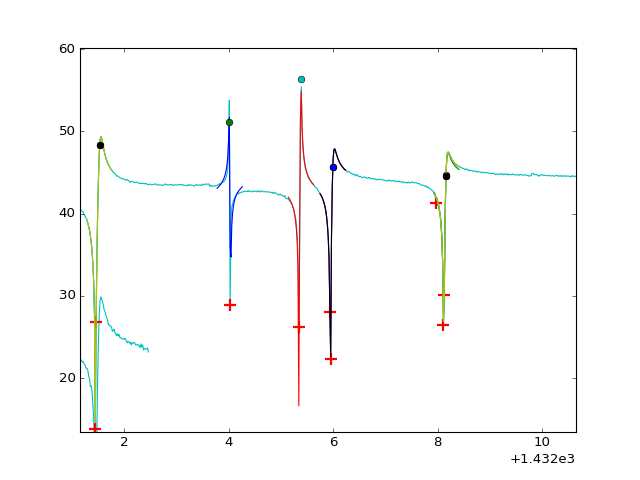

DEBUG: 2016-06-25 21:10:25,734 - kid_readout.find_resonators:11  Found 199 peaks
INFO: 2016-06-25 21:10:40,949 - kid_readout.find_resonators:20  Found possible resonator colision at 1043843750.0  1043394782.0
INFO: 2016-06-25 21:11:27,585 - kid_readout.find_resonators:20  Found possible resonator colision at 1100031438.6  1100319086.9
INFO: 2016-06-25 21:11:37,740 - kid_readout.find_resonators:20  Found possible resonator colision at 1106040658.7  1105737138.0
INFO: 2016-06-25 21:11:38,168 - kid_readout.find_resonators:20  Found possible resonator colision at 1105905800.3  1106040612.7
INFO: 2016-06-25 21:11:54,690 - kid_readout.find_resonators:20  Found possible resonator colision at 1143605076.8  1143467034.8
DEBUG: 2016-06-25 21:11:59,538 - kid_readout.find_resonators:11  Found 143 peaks
INFO: 2016-06-25 21:12:15,279 - kid_readout.find_resonators:20  Found possible resonator colision at 1287309794.3  1287538698.4
INFO: 2016-06-25 21:12:24,100 - kid_readout.find_resonators:20  Found 

In [12]:
resonators = []
for sa in sas:
    resonators.extend(find_resonators(sa.frequency, sa.s21_point, sa.s21_point_error,make_plot=True,
                            frequency_span=250e3,detect_peaks_kwargs=dict(edge='both'),detect_peaks_threshold=3))

In [13]:
clean = remove_duplicates(resonators)

found duplicate of  838113253.753 distance 1247.31597984
found duplicate of  839962488.451 distance 71.9029655457
found duplicate of  839962463.567 distance 96.7869185209
found duplicate of  846000243.34 distance 11.0804421902
found duplicate of  846000048.48 distance 183.779491186
found duplicate of  849996551.442 distance 236.255372286
found duplicate of  849996643.562 distance 328.375793219
found duplicate of  849996492.101 distance 176.914551735
found duplicate of  859966950.475 distance 38723.0626446
found duplicate of  859967267.9 distance 38405.637688
found duplicate of  868003960.107 distance 367.697417974
found duplicate of  880002677.853 distance 31.945800066
found duplicate of  880002705.936 distance 60.0287777185
found duplicate of  880002788.97 distance 143.062293172
found duplicate of  884031251.933 distance 6107.32293546
found duplicate of  889962305.325 distance 24.1824393272
found duplicate of  889962261.739 distance 19.4036830664
found duplicate of  889962231.781 dist

<IPython.core.display.Javascript object>


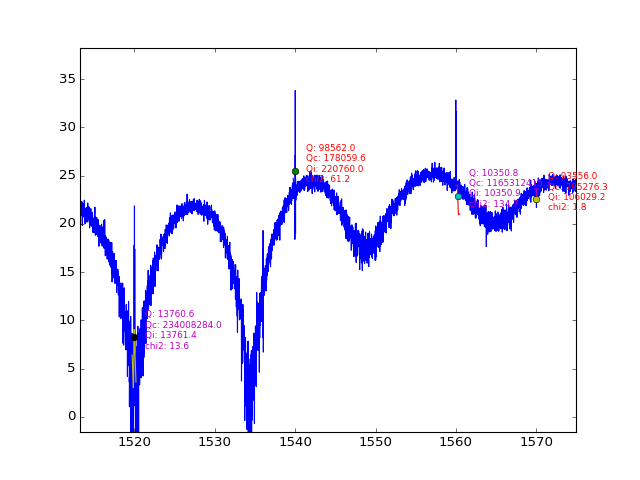

In [12]:
figure()
plot_results(sa.frequency,sa.s21_point,clean)

In [14]:
len(clean)

389

In [15]:
valid = [res for res in clean if validate_resonator(res)]

838112006.437 failed high Qer
839962560.354 failed shallow
846000232.26 847749775.351 failed shallow
847961515.254 849996315.186 failed multiple of 10 MHz
853525572.111 failed shallow
860005673.538 failed multiple of 10 MHz
862421874.938 failed low Qe
867160053.776 868004327.805 869781250.0 failed low range
877453178.851 880002645.907 failed multiple of 10 MHz
881075002.175 failed shallow
880937985.794 failed shallow
882265625.0 failed low Qe
884025144.61 889962281.143 failed shallow
891070091.878 failed shallow
893984374.998 failed high range
894726779.989 897371729.64 failed high Qer
898140625.0 failed low range
899995484.506 failed shallow
900484375.0 failed low range
902316914.72 903736027.51 905136227.147 907698277.295 909144491.341 909536138.39 910011856.754 910458644.538 914618069.366 915404733.172 failed high Qer
916229640.601 916637928.61 916904328.731 918170862.349 920027631.896 failed high Qe
923812451.336 930019310.42 failed shallow
929896224.157 failed shallow
933252196.05

In [16]:
len(valid)

185

In [17]:
frequency = np.hstack([sa.frequency for sa in sas])
s21 = np.hstack([sa.s21_point for sa in sas])

<IPython.core.display.Javascript object>


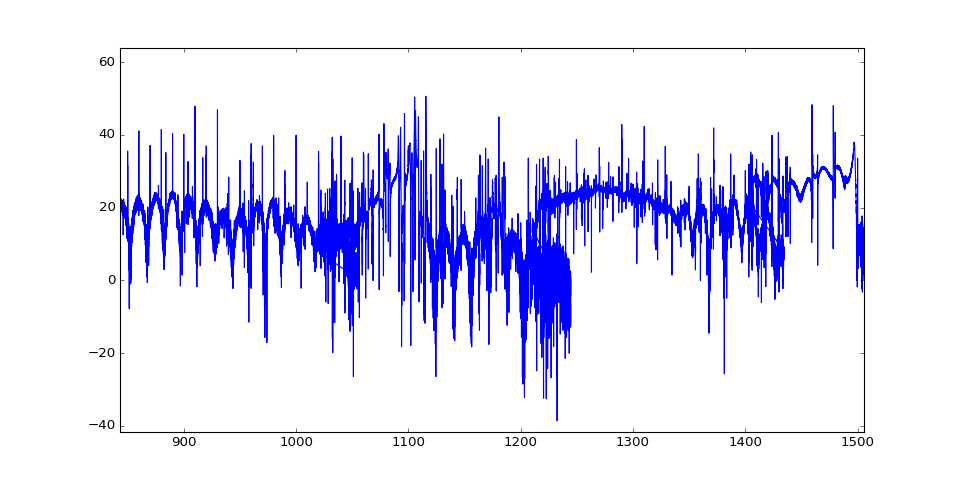

In [20]:
figure(figsize=(12,6))
plot(frequency/1e6,dB(s21))

<IPython.core.display.Javascript object>


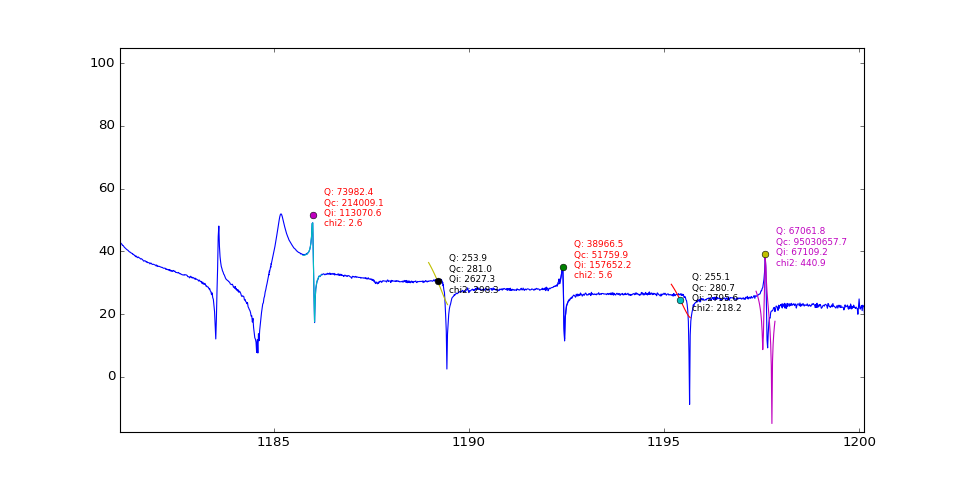

In [18]:
figure(figsize=(12,6))
plot_results(frequency,s21,clean,annotate=True)
#for x in np.arange(frequency.min(),frequency.max(),2*750e3)/1e6:
#    axvline(x,color='k',alpha=0.1)

In [19]:
len(sas)

4

In [21]:
fold = sa.s21_raw.reshape((16384,-1,256)).mean(1)

In [23]:
foldn = fold - fold.mean(1)[:,None]

<IPython.core.display.Javascript object>


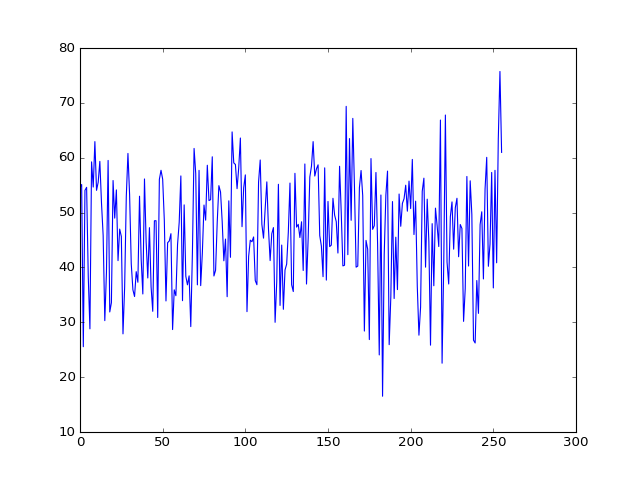

In [28]:
figure()
plot(np.abs(foldn[13135,:]))

<IPython.core.display.Javascript object>


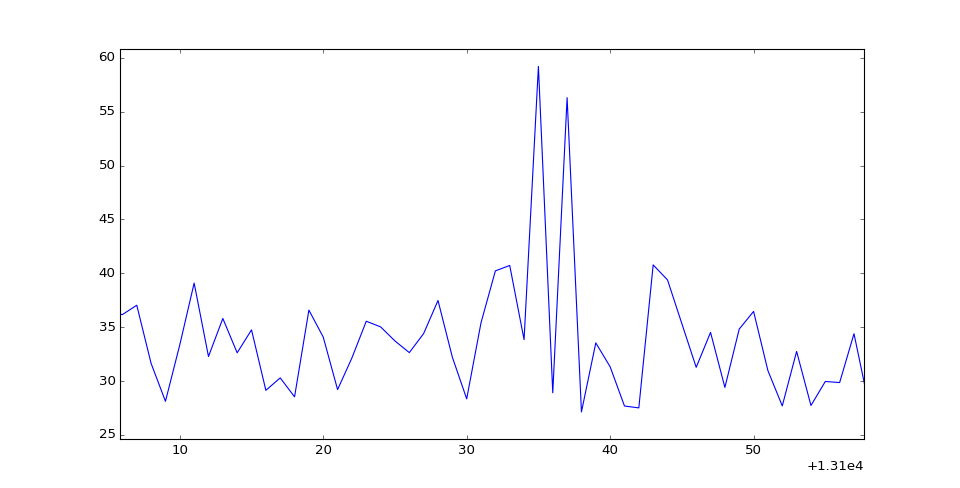

In [24]:
figure(figsize=(12,6))
plot(np.abs(foldn).ptp(1))

In [38]:
bp = np.median(np.array([dB(sa.s21_point) for sa in sas]),0)

In [39]:
bp.shape

(16384,)

In [42]:
f0=np.array([res.f_0 for res in valid])

In [45]:
sa.stream_arrays[0].roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr16gb_2016_Jun_08_1100.bof', u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 1400000000.0, u'adc_sample_rate': 512000000.0, u'modulation_output': 2, u'waveform_normalization': 0.00213623046875, u'num_tones': 256, u'modulation_rate': 7, u'debug_register': 0, u'dac_attenuation': 20.0, u'num_tone_samples': 32768, u'bank': 0, u'heterodyne': True})

<IPython.core.display.Javascript object>


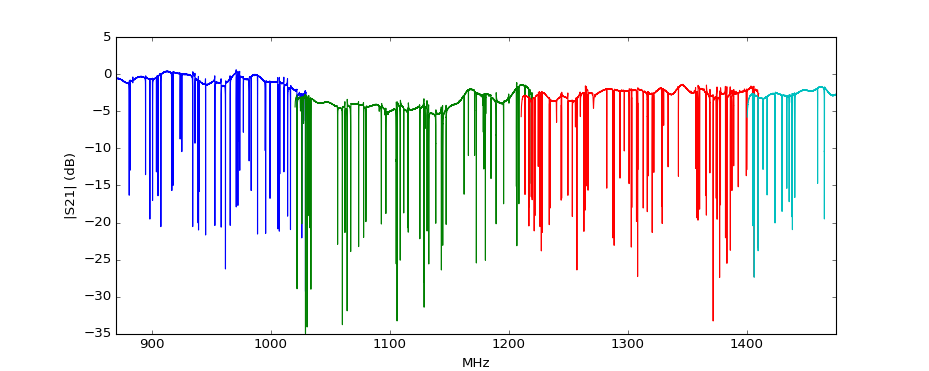

In [51]:
figure(figsize=(9,3))
for sa in sas:
    freq = sa.frequency_MHz
    bb = (sa.frequency-sa.stream_arrays[0].roach_state['lo_frequency'])/1e6
    bp = bb*(-10/200.)
    dbs21 = dB(sa.s21_point)-bp
    mask = (np.mod(freq,10.0) > .1) & (np.abs(np.mod(freq,10.0)-10.0) > .1) & (bb<200.)
    plot(freq[mask],dbs21[mask]-60)
ax = gca()
#ax.xaxis.set_major_locator(plt.MultipleLocator(20))
xlim(870,1475)
ax.set_ylabel('|S21| (dB)')
ax.set_xlabel('MHz')
#savefig('2016-06-23-hex-271-sweep.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


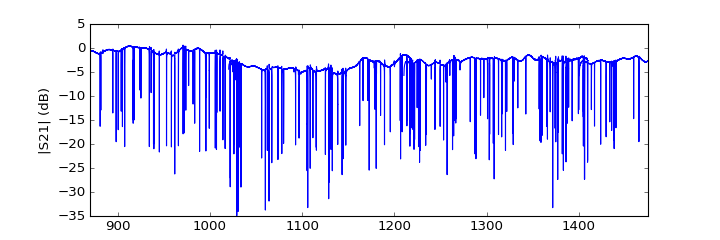

In [50]:
figure(figsize=(9,3))
for sa in sas:
    freq = sa.frequency_MHz
    bb = (sa.frequency-sa.stream_arrays[0].roach_state['lo_frequency'])/1e6
    bp = bb*(-10/200.)
    dbs21 = dB(sa.s21_point)-bp
    mask = (np.mod(freq,10.0) > .1) & (np.abs(np.mod(freq,10.0)-10.0) > .1) & (bb<200.)
    plot(freq[mask],dbs21[mask]-60,'b')
ax = gca()
#ax.xaxis.set_major_locator(plt.MultipleLocator(20))
xlim(870,1475)
ax.set_ylabel('|S21| (dB)')
ax.set_xlabel('MHz')
#savefig('2016-06-23-hex-271-sweep-same-color.pdf',bbox_inches='tight')

In [186]:
Qs=[res.Q for res in valid]

In [196]:
Qi = np.array([res.Q_i for res in valid])

In [188]:
Qc = [1/(np.real(1/res.Q_e)) for res in valid]

In [59]:
f0=np.array([res.f_0 for res in valid])

In [60]:
f0.shape

(177,)

In [61]:
np.save('/artemis/readout/resonances/2016-06-24-jpl-hex-271-all-auto-found-resonators.npy',f0)

In [217]:
mindifflist = f0[np.flatnonzero(np.diff(f0)>8*512e6/2**14)]

In [218]:
mindifflist.shape

(174,)

In [208]:
plot(f0)

In [190]:
np.median(f0)/1e6

1206.3700320657672

In [219]:
lo_1210_128=np.sort(mindifflist[np.sort(np.argsort(np.abs(mindifflist-1210e6))[:128])])

In [220]:
lo_1210_128.shape

(128,)

In [223]:
lo_1210_128

array([  9.99327257e+08,   1.00583564e+09,   1.00713254e+09,
         1.00752397e+09,   1.01098044e+09,   1.01407935e+09,
         1.01653087e+09,   1.02201442e+09,   1.02491063e+09,
         1.02601717e+09,   1.02749555e+09,   1.02911411e+09,
         1.03049176e+09,   1.03117267e+09,   1.03204778e+09,
         1.03257555e+09,   1.05610171e+09,   1.06015116e+09,
         1.06226744e+09,   1.06414088e+09,   1.06712588e+09,
         1.07376128e+09,   1.07794512e+09,   1.07990158e+09,
         1.09110041e+09,   1.09291421e+09,   1.09604144e+09,
         1.10538025e+09,   1.10572288e+09,   1.10610250e+09,
         1.10876096e+09,   1.11166011e+09,   1.11550686e+09,
         1.12520073e+09,   1.12875781e+09,   1.12995807e+09,
         1.13127615e+09,   1.13269388e+09,   1.13860098e+09,
         1.14330718e+09,   1.14441677e+09,   1.14731954e+09,
         1.16241086e+09,   1.16602466e+09,   1.17121048e+09,
         1.17270430e+09,   1.17896729e+09,   1.18031574e+09,
         1.18060189e+09,

<IPython.core.display.Javascript object>


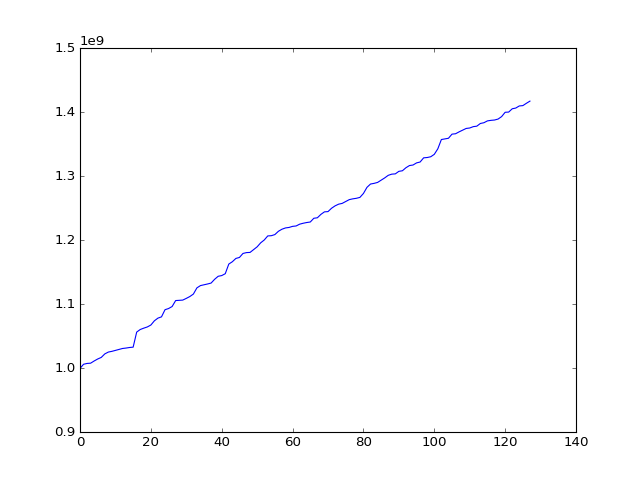

In [224]:
plot(lo_1210_128)

In [225]:
np.diff(lo_1210_128).min()

286149.50400972366

In [227]:
np.save('/artemis/readout/resonances/2016-06-22-lo-1210-128-resonances.npy',lo_1210_128)

In [177]:
np.mod(999.9e6,10e6)

9900000.0

In [178]:
np.array(f0)[(np.abs(np.mod(f0,10.0e6)) < 10e3) | (np.abs(np.mod(f0,10.0e6)-10e6) < 10e3)]/1e6

array([  959.99913324,   969.99455813,   979.99485914,   999.99431954,
        1010.00524783,  1020.00772099,  1480.00287086])

<IPython.core.display.Javascript object>


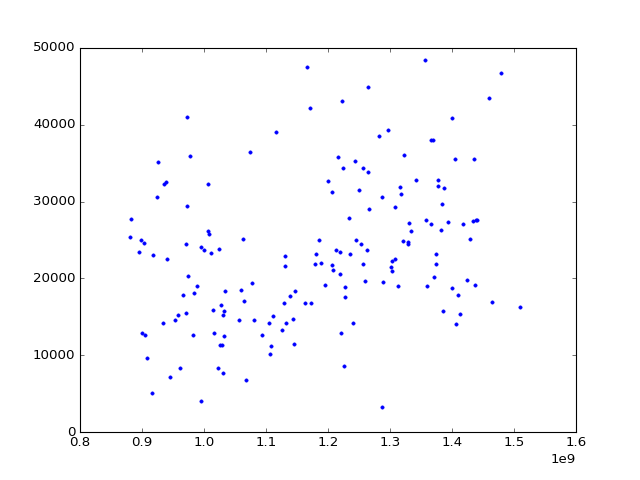

(0, 50000)

In [148]:
plot(f0,Qc,'.')
ylim(0,50000)

<IPython.core.display.Javascript object>


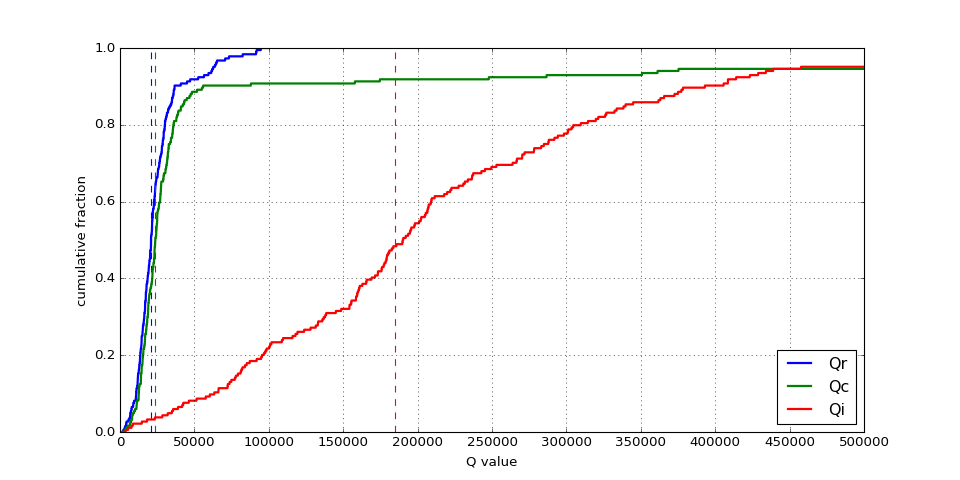

In [160]:
figure(figsize=(12,6))
h,edges = np.histogram(Qs,bins=np.arange(0,100e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qr',color='b',lw=2)
axvline(np.median(Qs),color='b',linestyle='--')
h,edges = np.histogram(Qc,bins=np.arange(0,500e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qc',color='g',lw=2)
axvline(np.median(Qc),color='g',linestyle='--')
h,edges = np.histogram(Qi,bins=np.arange(0,500e3,100))
plot(edges[:-1],np.cumsum(h)*1./len(Qs),label='Qi',color='r',lw=2)
axvline(np.median(Qi),color='r',linestyle='--')
ylabel('cumulative fraction')
xlabel('Q value')
grid()
legend(loc='lower right')
gca().xaxis.set_major_locator(plt.MultipleLocator(50e3))

<IPython.core.display.Javascript object>


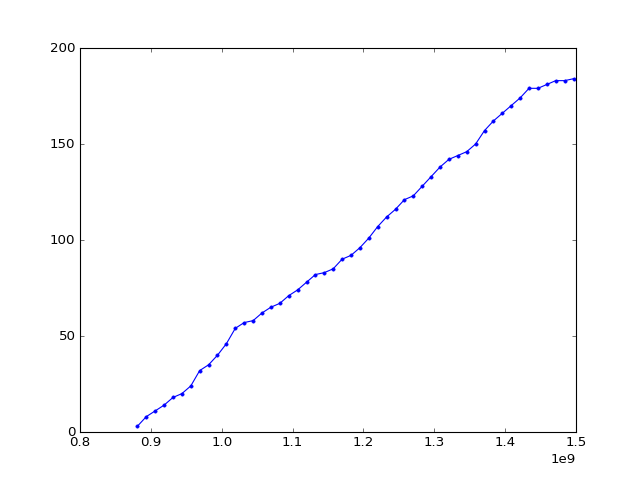

In [159]:
h,edges = np.histogram(f0,bins=50)
plot(edges[:-1],np.cumsum(h),'.-')

<IPython.core.display.Javascript object>


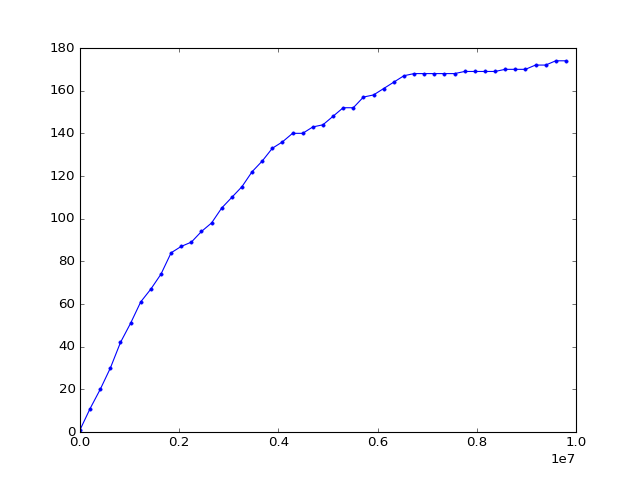

In [166]:
h,edges = np.histogram(np.diff(f0),bins=np.linspace(0,10e6,50))
plot(edges[:-1],np.cumsum(h),'.-')